In [7]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = "/content/drive/My Drive/RM_Segmentation_Assignment_dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

!pip install pycocotools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import zipfile

# This is the correct path based on your screenshot
zip_path = "/content/RM_Segmentation_Assignment_dataset.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset extracted successfully!")


 Dataset extracted successfully!


Epoch 1, Loss: 16.9960
Epoch 2, Loss: 12.7559
Epoch 3, Loss: 10.9050
Epoch 4, Loss: 8.8409
Epoch 5, Loss: 8.4809
 Training completed. Now displaying results...


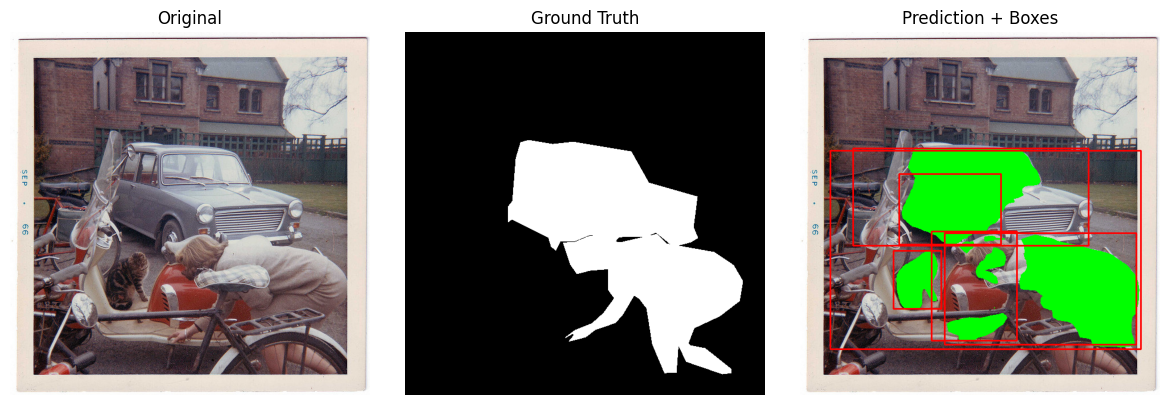

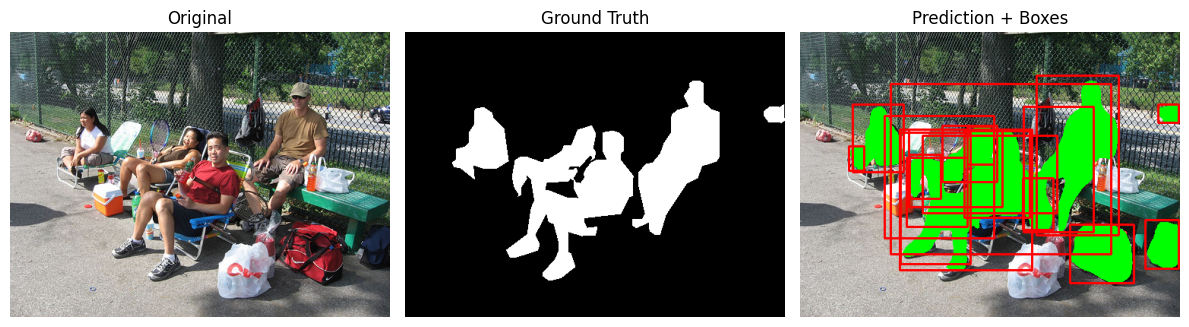

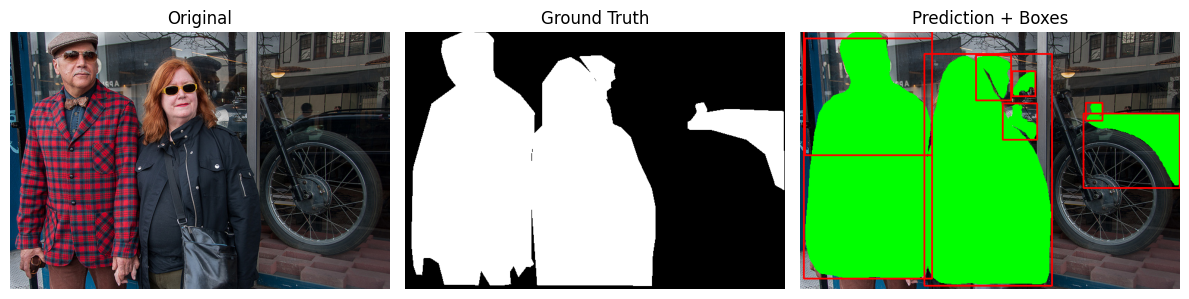

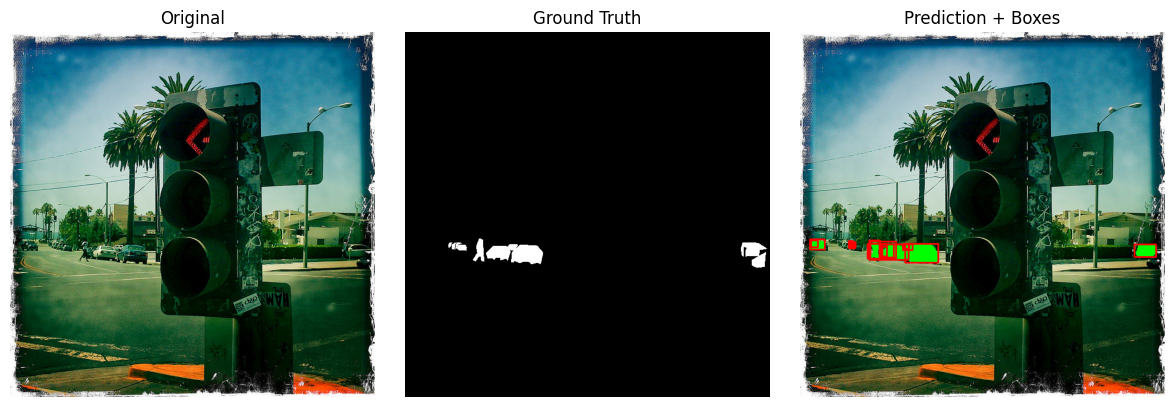

In [40]:
import os, json, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as TF
from pycocotools.mask import decode, frPyObjects

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to training data
ROOT_IMG = '/content/dataset/train-300/data'
ROOT_JSON = '/content/dataset/train-300/labels.json'

# Load COCO-style annotations
def read_coco(json_path):
    with open(json_path, 'r') as f:
        coco = json.load(f)
    name_map = {c['id']: c['name'] for c in coco['categories']}
    target = [k for k, v in name_map.items() if v in ['person', 'car', 'dog', 'cake']]
    return coco['images'], coco['annotations'], target

# Dataset class with only relevant categories and at least one dog
class ImageSegDataset(Dataset):
    def __init__(self, img_dir, ann_path, use_top=30):
        self.img_dir = img_dir
        images, self.annots, self.cat_ids = read_coco(ann_path)
        self.lookup = defaultdict(list)
        for a in self.annots:
            self.lookup[a['image_id']].append(a)

        self.eligible = []
        for im in images:
            anns = self.lookup[im['id']]
            if any(an['category_id'] in self.cat_ids for an in anns):
                self.eligible.append(im)

        # Force 1 dog image
        has_dog = [im for im in self.eligible if any(an['category_id'] == 18 for an in self.lookup[im['id']])]
        others = [im for im in self.eligible if im not in has_dog]

        random.shuffle(has_dog)
        random.shuffle(others)
        self.eligible = has_dog[:1] + others[:use_top - 1]

    def __len__(self):
        return len(self.eligible)

    def __getitem__(self, idx):
        meta = self.eligible[idx]
        path = os.path.join(self.img_dir, meta['file_name'])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tens = TF.to_tensor(image)

        masks, labels, boxes = [], [], []
        for ann in self.lookup[meta['id']]:
            if ann['category_id'] in self.cat_ids:
                rle = frPyObjects(ann['segmentation'], meta['height'], meta['width'])
                m = decode(rle)
                if m.ndim == 3:
                    m = m[:, :, 0]
                m = m.astype(np.uint8)
                masks.append(torch.tensor(m))
                labels.append(torch.tensor(1))
                y, x = np.where(m)
                if x.size and y.size:
                    boxes.append(torch.tensor([x.min(), y.min(), x.max(), y.max()], dtype=torch.float32))

        target = {
            'boxes': torch.stack(boxes) if boxes else torch.zeros((0, 4), dtype=torch.float32),
            'labels': torch.stack(labels) if labels else torch.zeros((0,), dtype=torch.int64),
            'masks': torch.stack(masks) if masks else torch.zeros((0, image.shape[0], image.shape[1]), dtype=torch.uint8),
            'image_id': torch.tensor([meta['id']])
        }
        return tens, target

# Train model
def train():
    dataset = ImageSegDataset(ROOT_IMG, ROOT_JSON, use_top=30)
    loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    model = maskrcnn_resnet50_fpn(weights='DEFAULT')
    model.to(DEVICE).train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    for epoch in range(5):
        total = 0.0
        for imgs, targets in loader:
            imgs = [im.to(DEVICE) for im in imgs]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            losses = model(imgs, targets)
            loss = sum(losses.values())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total:.4f}")
    return model

# Run prediction
def run_predict(model, image):
    model.eval()
    with torch.no_grad():
        timg = TF.to_tensor(image).unsqueeze(0).to(DEVICE)
        out = model(timg)[0]
        mask = torch.any(out['masks'] > 0.5, dim=0)[0].cpu().numpy().astype(np.uint8)
        boxes = out['boxes'].detach().cpu().numpy().astype(np.int32)
        return mask, boxes

# Visualize predictions
def display_results(model):
    ds = ImageSegDataset(ROOT_IMG, ROOT_JSON, use_top=30)
    for i in range(4):  # Show 4 images only
        img_t, tgt = ds[i]
        img_np = (img_t.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        gt_mask = torch.any(tgt['masks'].bool(), dim=0).numpy().astype(np.uint8)
        pred_mask, boxes = run_predict(model, img_np)

        overlay = img_np.copy()
        overlay[pred_mask == 1] = [0, 255, 0]
        for box in boxes:
            x1, y1, x2, y2 = box
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Prediction + Boxes")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Run everything
model_c = train()
print(" Training completed. Now displaying results...")
display_results(model_c)